In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [243]:
# Load the dataset
def load_data(file_path):
    return pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

df = load_data("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(df.shape)  # Check if df is loaded correctly

(1470, 35)


In [244]:
# Perform initial data inspection
def initial_inspection(df):
    print("Total number of records:", df.shape[0])
    print("Column types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nBasic statistics:")
    print(df.describe())
initial_inspection(df)


Total number of records: 1470
Column types:
Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOption

In [245]:
def handle_missing_values(df):
    print("\nMissing Data Patterns:")
    print(df.isnull().sum())
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df


In [246]:
# Remove duplicate records
def remove_duplicates(df):
    print("\nDuplicate Records Removed:", df.duplicated().sum())
    return df.drop_duplicates()
df = remove_duplicates(df)
print(df.shape)  # Ensure df is not None



Duplicate Records Removed: 0
(1470, 35)


In [247]:
# Address outliers using IQR method
def remove_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df




In [248]:
print(df['MaritalStatus'].unique())

['Single' 'Married' 'Divorced']


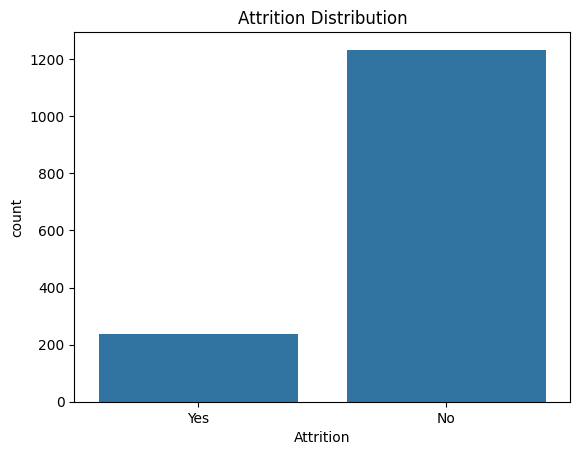

Age                         int64
Attrition                   int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EmployeeNumber              int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesL

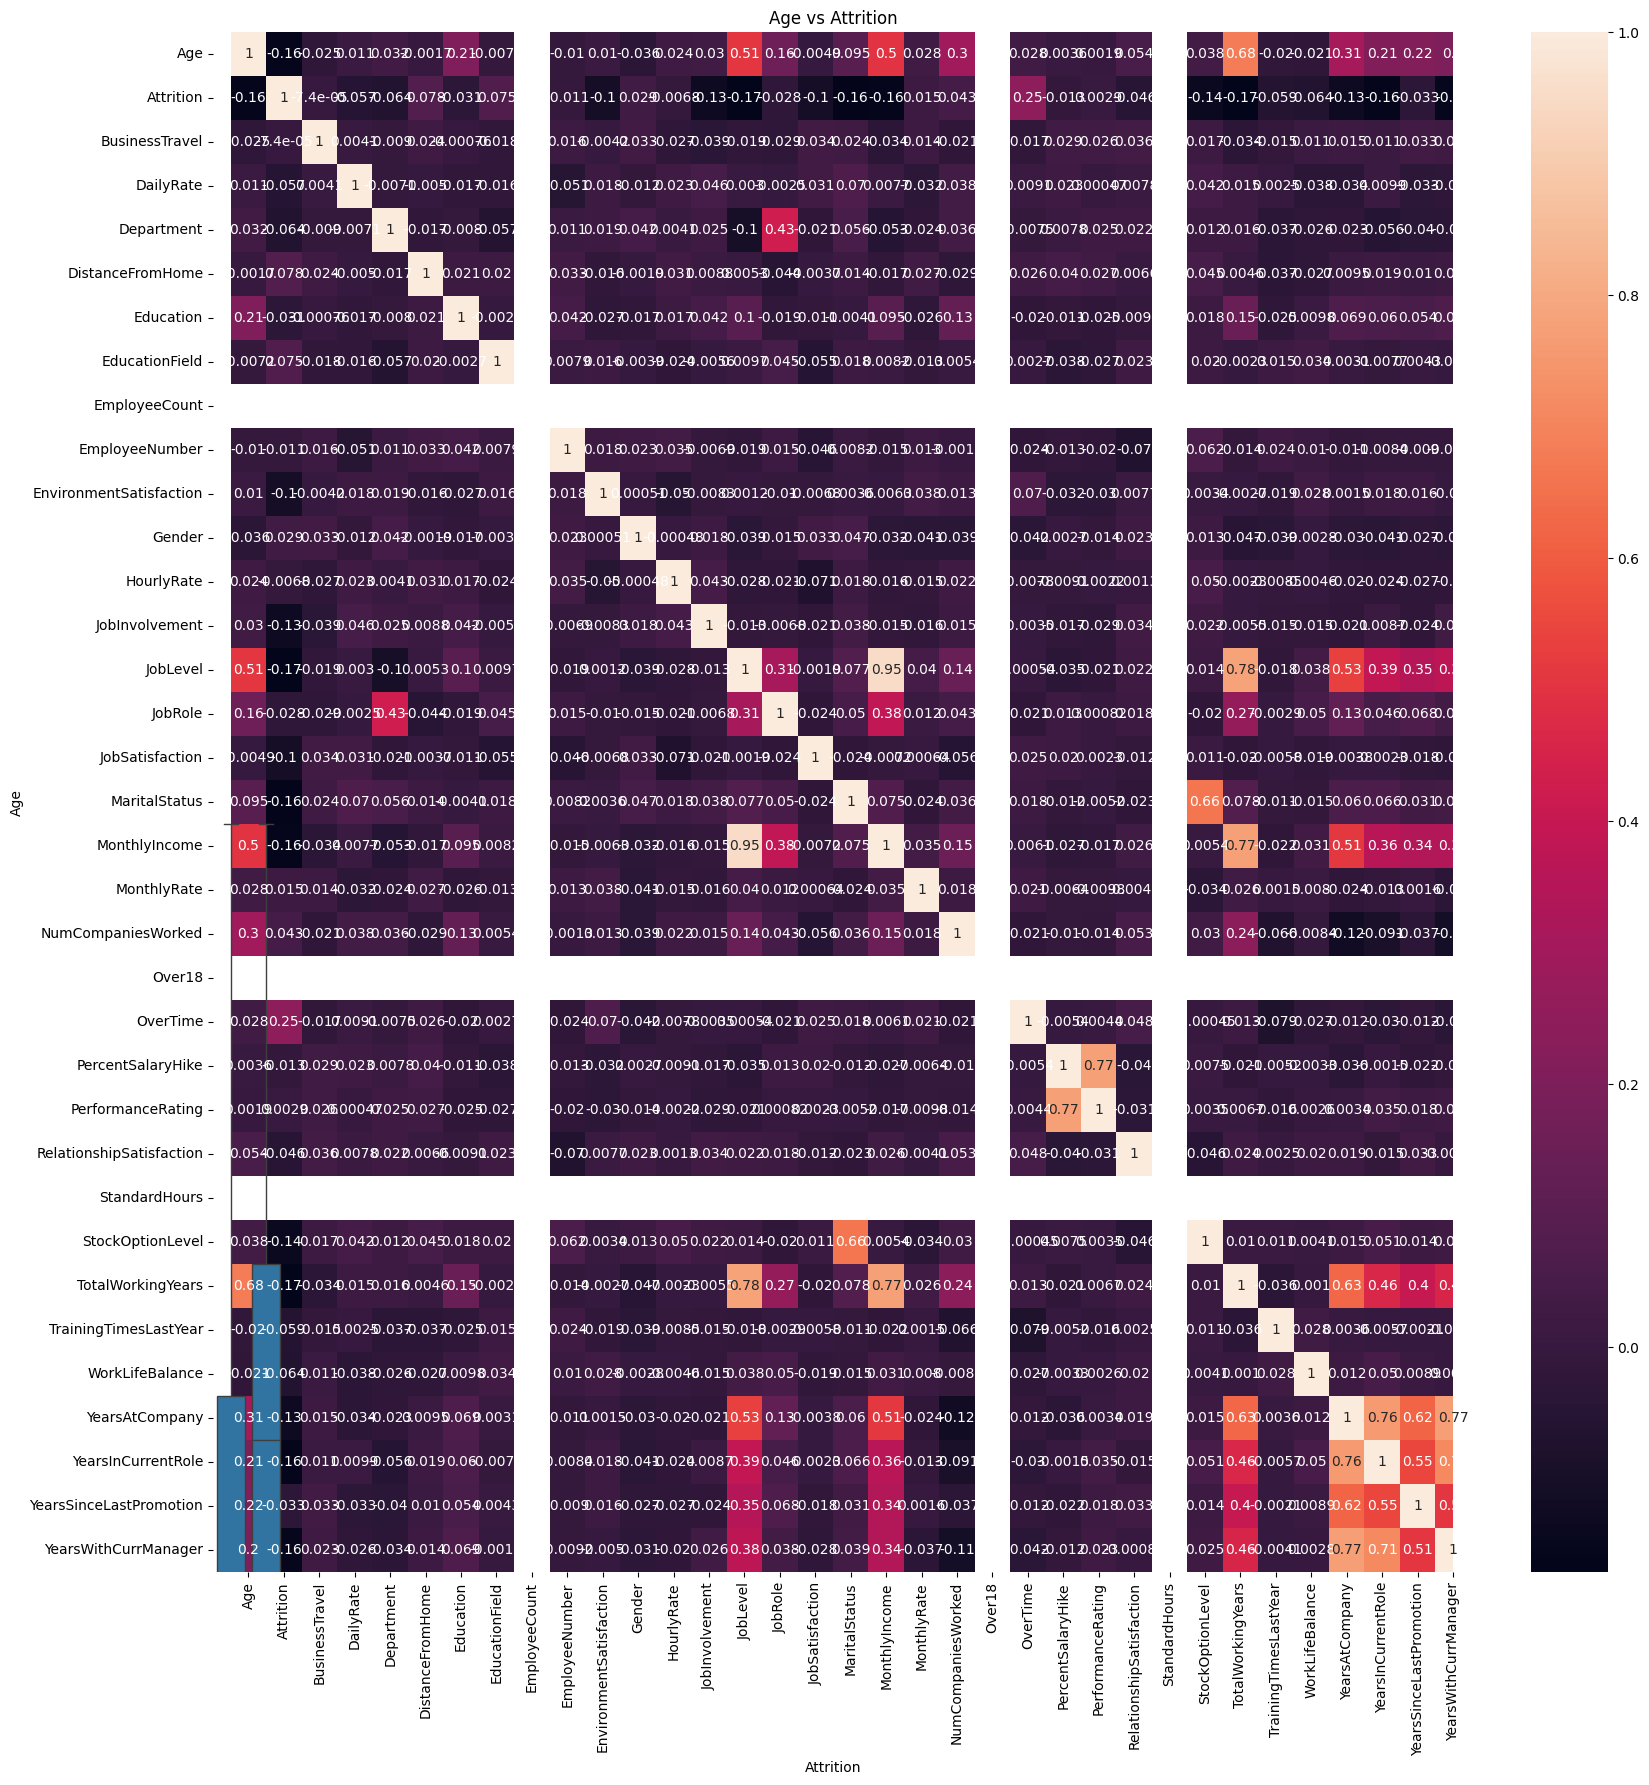

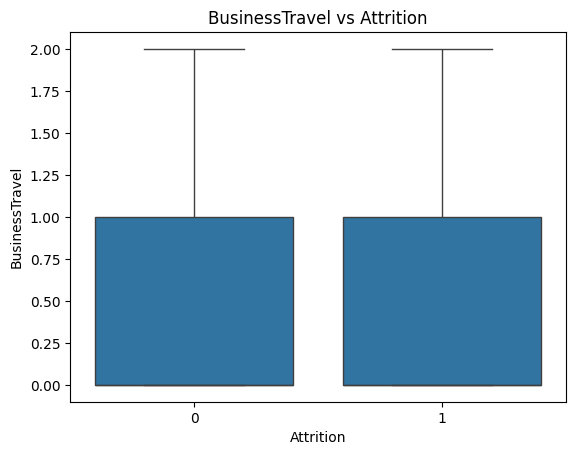

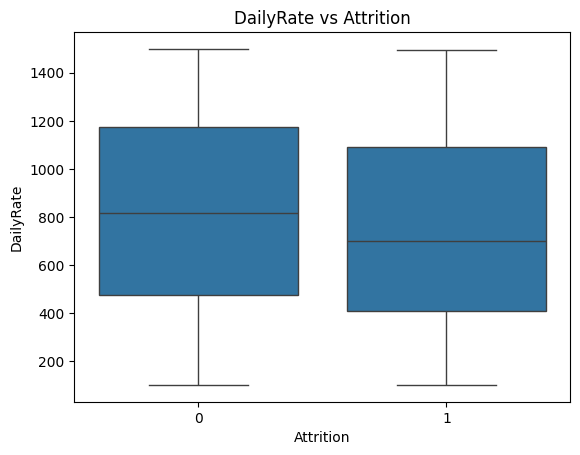

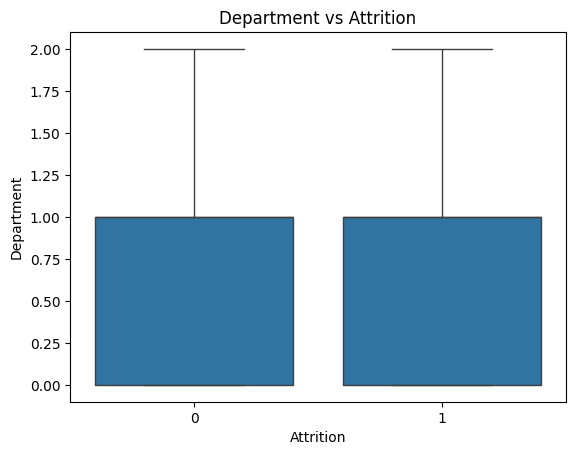

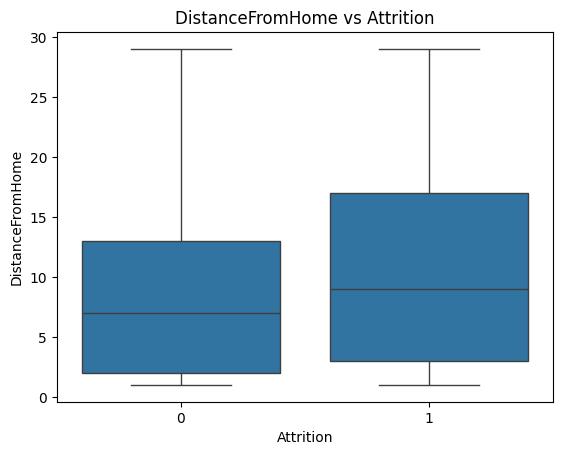

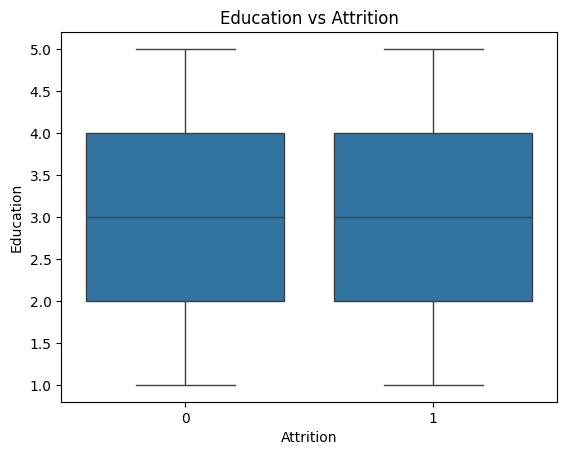

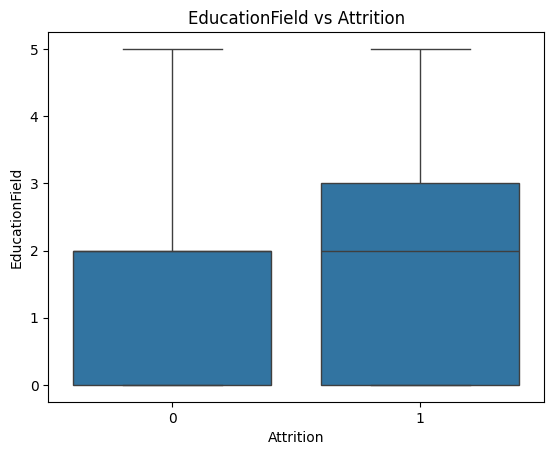

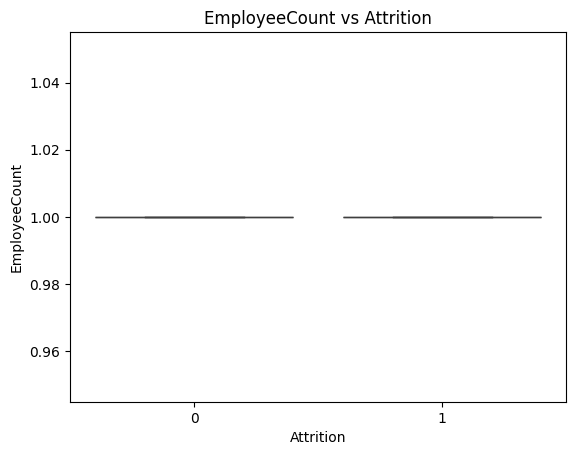

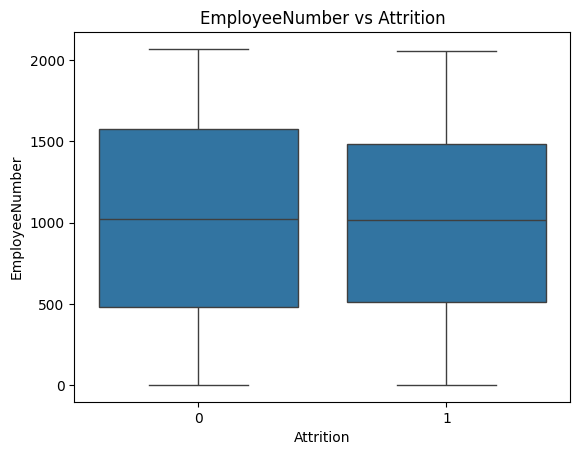

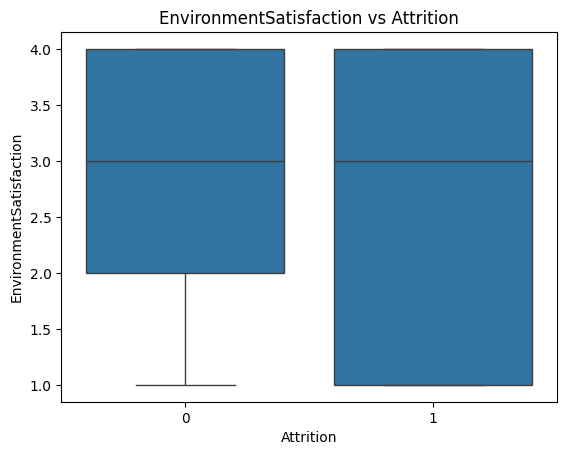

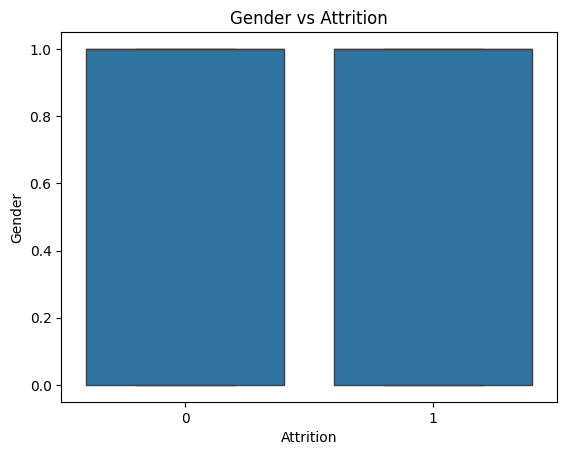

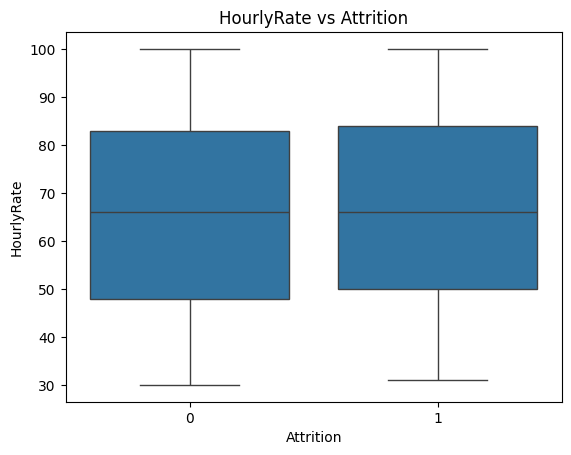

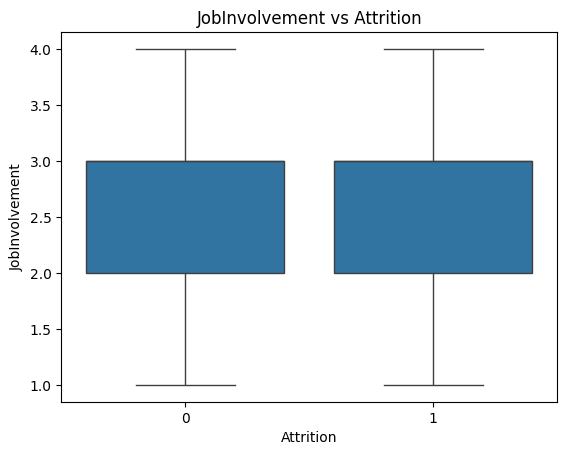

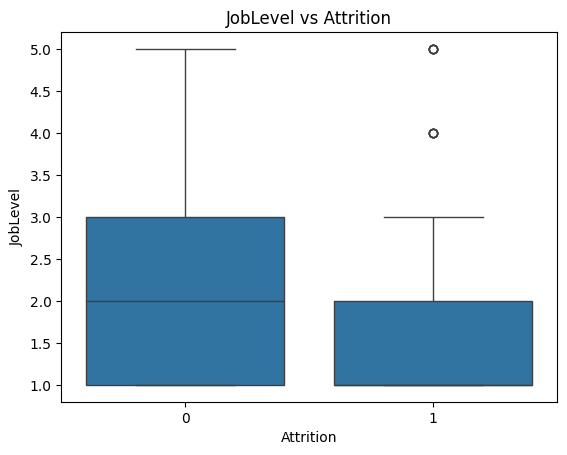

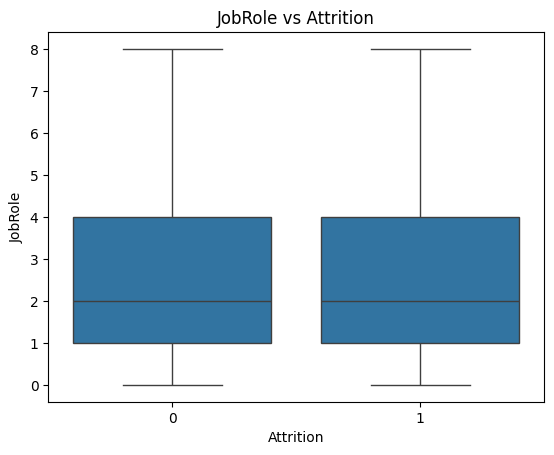

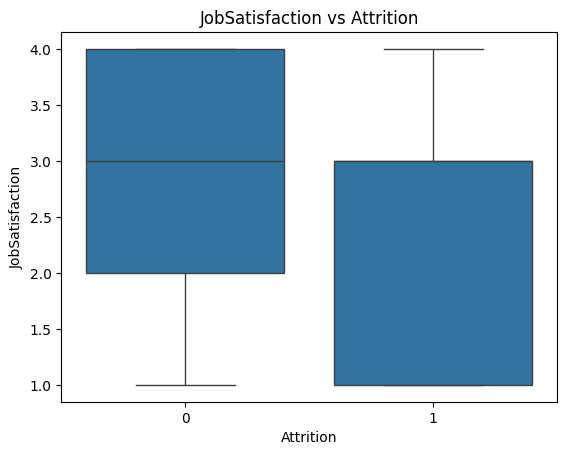

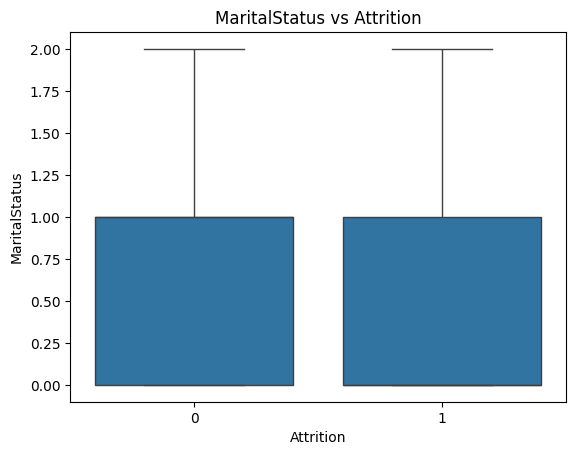

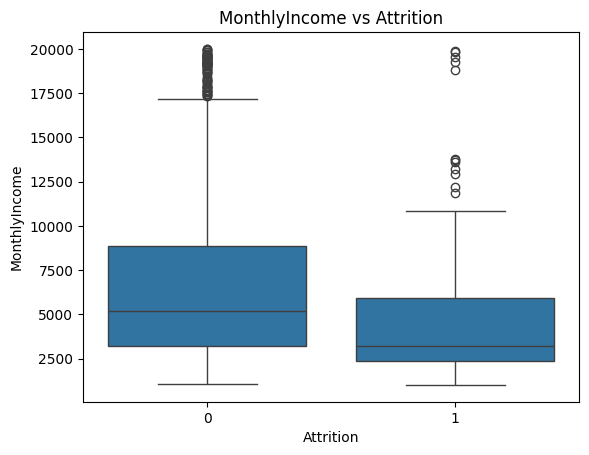

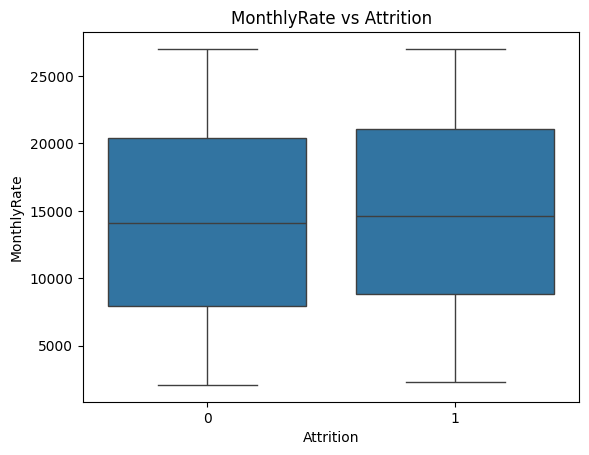

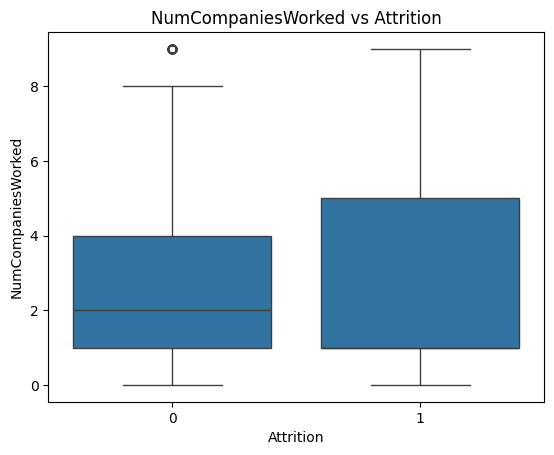

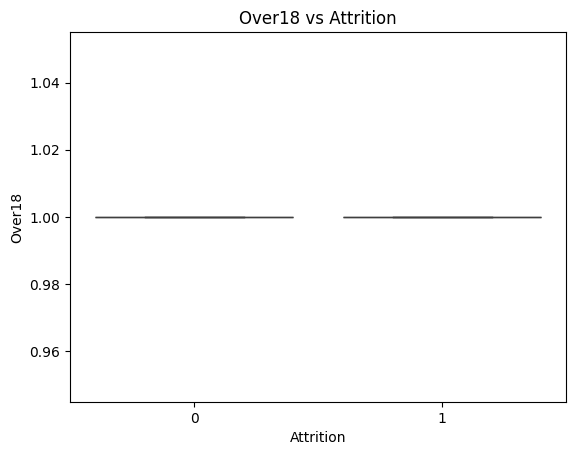

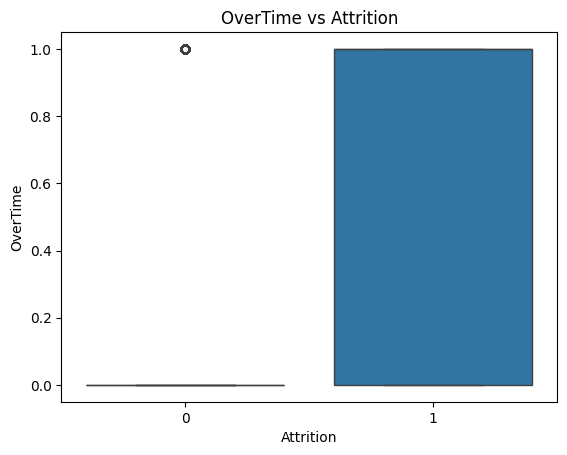

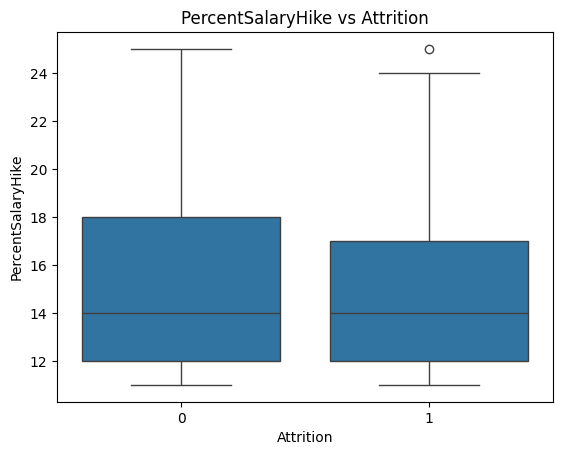

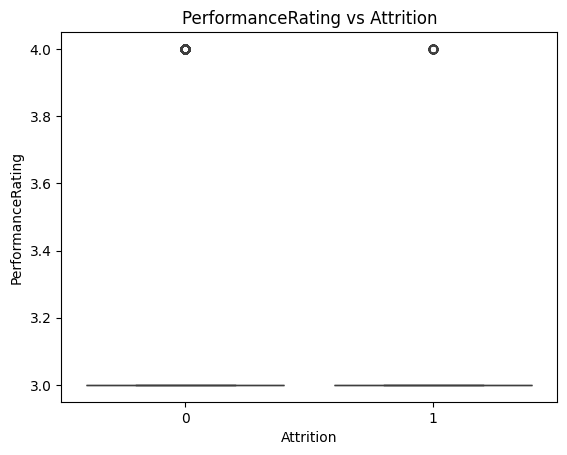

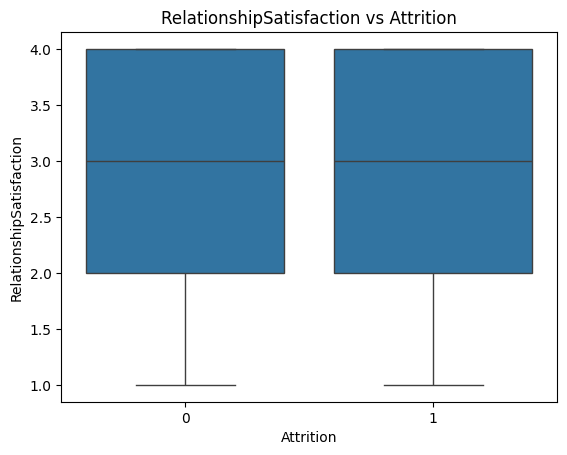

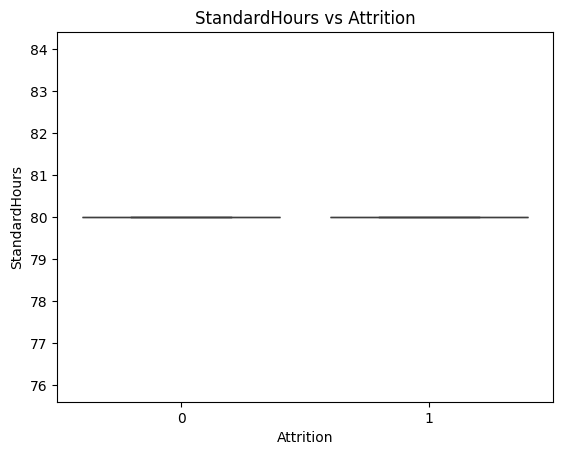

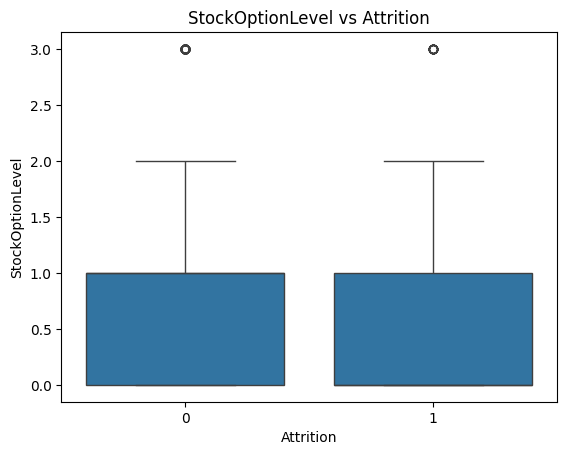

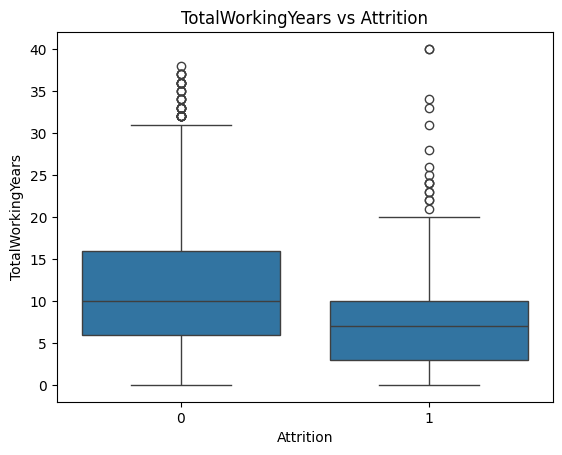

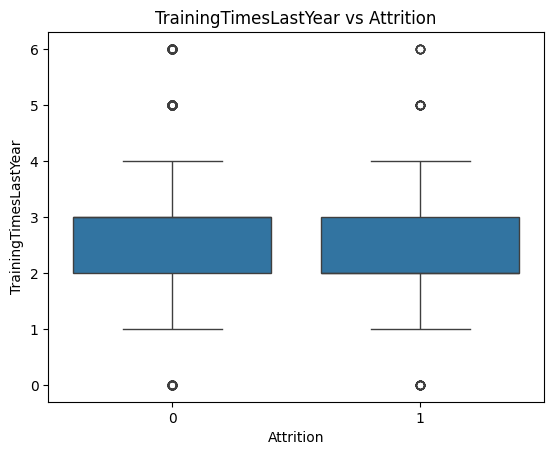

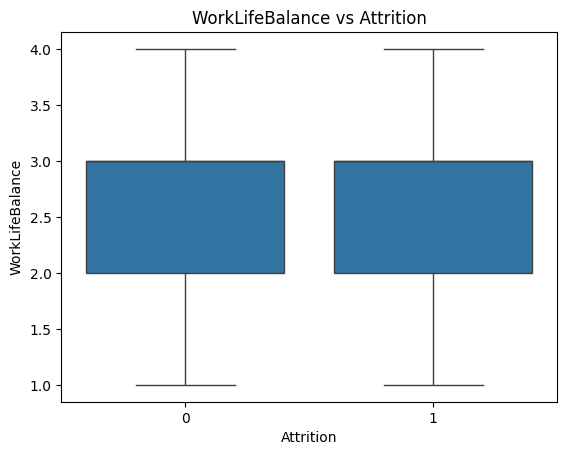

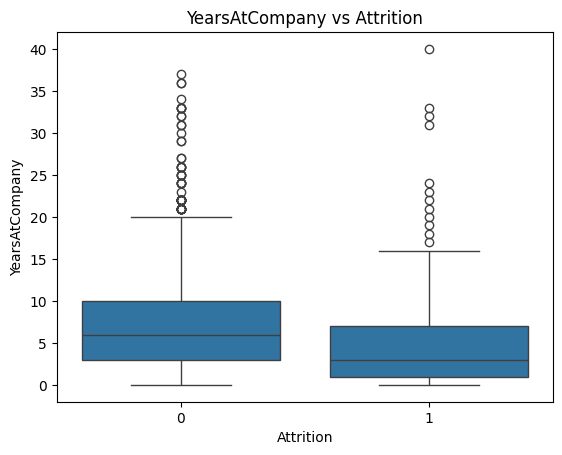

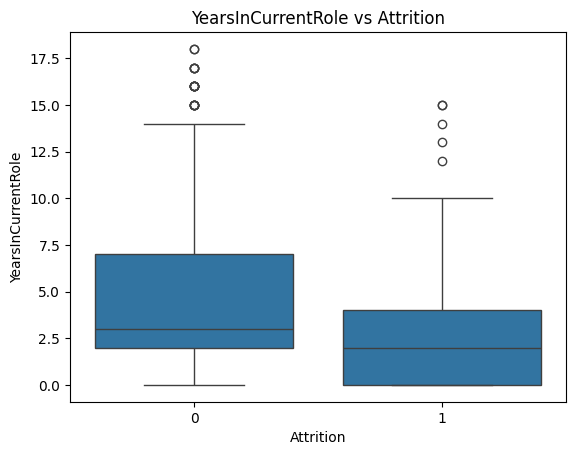

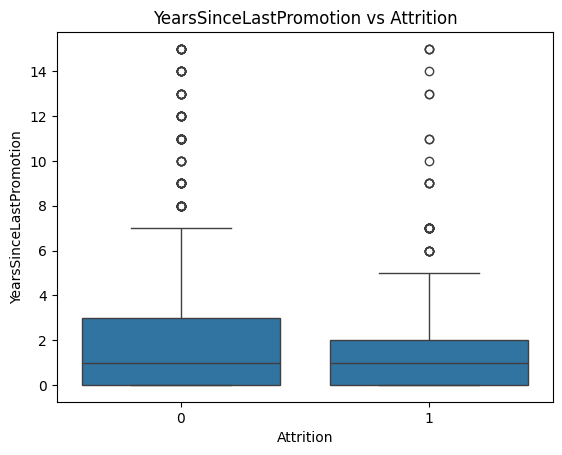

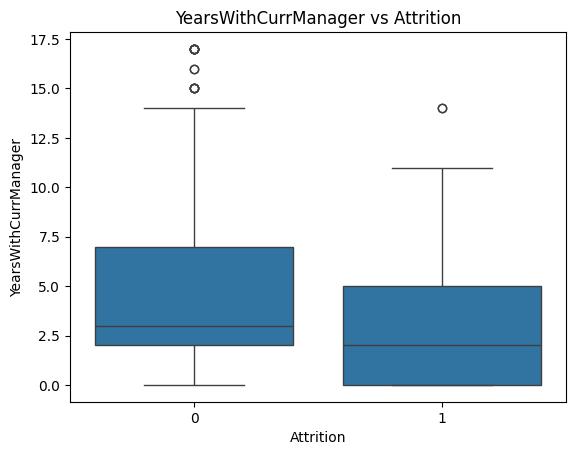

In [249]:
# Exploratory Data Analysis (EDA)

def visualize_data(df):
    # Distribution of Attrition
    if 'Attrition' in df.columns:
        sns.countplot(x=df['Attrition'])
        plt.title("Attrition Distribution")
        plt.show()
       # EducationField
    df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: list(df['MaritalStatus'].unique()).index(x))
    df['JobRole'] = df['JobRole'].apply(lambda x: list(df['JobRole'].unique()).index(x))
    df['Gender'] = df['Gender'].apply(lambda x: list(df['Gender'].unique()).index(x))
    df['EducationField'] = df['EducationField'].apply(lambda x: list(df['EducationField'].unique()).index(x))
    df['Department'] = df['Department'].apply(lambda x: list(df['Department'].unique()).index(x))
    df['BusinessTravel'] = df['BusinessTravel'].apply(lambda x: list(df['BusinessTravel'].unique()).index(x))
    #['JobRole'] = df['JobRole'].apply(lambda x: list(df['JobRole'].unique()).index(x))
    df['OverTime'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
    df['Over18'] = df['Over18'].apply(lambda x: 1 if x == 'Y' else 0)
    df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
    # Correlation Heatmap
    print(df.dtypes)

    correlations = df.corr()

    f, ax = plt.subplots(figsize = (20, 20))

    sns.heatmap(correlations, annot = True)

    # Key Factors Influencing Attrition
    if 'Attrition' in df.columns:
        for col in df.select_dtypes(include=['number']).columns:
            if col != 'Attrition':
                sns.boxplot(x=df['Attrition'], y=df[col])
                plt.title(f"{col} vs Attrition")
                plt.show()
visualize_data(df)




In [250]:
# 4.2 Statistical Analysis
def statistical_analysis(df):
    if 'Attrition' in df.columns:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        num_cols = df.select_dtypes(include=[np.number]).columns

        # Chi-square test for categorical variables
        for col in cat_cols:
            if col != 'Attrition':
                contingency_table = pd.crosstab(df[col], df['Attrition'])
                chi2, p, _, _ = chi2_contingency(contingency_table)
                print(f"Chi-square test for {col}: p-value = {p:.4f}")

        # T-tests for numerical variables
        for col in num_cols:
            if col != 'Attrition':
                group1 = df[df['Attrition'] == 1][col]
                group2 = df[df['Attrition'] == 0][col]
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                print(f"T-test for {col}: p-value = {p_val:.4f}")

        # ANOVA for multiple group comparisons (if applicable)
        if 'Department' in df.columns:
            groups = [df[df['Department'] == dept]['Attrition'] for dept in df['Department'].unique()]
            f_stat, p_val = f_oneway(*groups)
            print(f"ANOVA for Department: p-value = {p_val:.4f}")
statistical_analysis(df)

T-test for Age: p-value = 0.0000
T-test for BusinessTravel: p-value = 0.9977
T-test for DailyRate: p-value = 0.0299
T-test for Department: p-value = 0.0141
T-test for DistanceFromHome: p-value = 0.0028
T-test for Education: p-value = 0.2293
T-test for EducationField: p-value = 0.0038
T-test for EmployeeCount: p-value = nan
T-test for EmployeeNumber: p-value = 0.6853
T-test for EnvironmentSatisfaction: p-value = 0.0001
T-test for Gender: p-value = 0.2591
T-test for HourlyRate: p-value = 0.7931
T-test for JobInvolvement: p-value = 0.0000
T-test for JobLevel: p-value = 0.0000
T-test for JobRole: p-value = 0.2845
T-test for JobSatisfaction: p-value = 0.0001
T-test for MaritalStatus: p-value = 0.0000
T-test for MonthlyIncome: p-value = 0.0000
T-test for MonthlyRate: p-value = 0.5611
T-test for NumCompaniesWorked: p-value = 0.0955
T-test for Over18: p-value = nan
T-test for OverTime: p-value = 0.0000
T-test for PercentSalaryHike: p-value = 0.6056
T-test for PerformanceRating: p-value = 0.911

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [251]:
# Feature Selection
def feature_selection(df):
    # Correlation analysis
    corr_matrix = df.corr()
    print("Correlation Matrix:\n", corr_matrix)

    # Mutual information
    if 'Attrition' in df.columns:
        mi = mutual_info_classif(df.drop(columns=['Attrition']), df['Attrition'])
        print("Mutual Information Scores:", mi)

    # Feature importance from tree-based models
    if 'Attrition' in df.columns:
        model = RandomForestClassifier()
        model.fit(df.drop(columns=['Attrition']), df['Attrition'])
        print("Feature Importances:", model.feature_importances_)

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df.select_dtypes(include=[np.number]))
    print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
feature_selection(df)


Correlation Matrix:
                                Age  Attrition  BusinessTravel  DailyRate  \
Age                       1.000000  -0.159205       -0.024751   0.010661   
Attrition                -0.159205   1.000000       -0.000074  -0.056652   
BusinessTravel           -0.024751  -0.000074        1.000000   0.004086   
DailyRate                 0.010661  -0.056652        0.004086   1.000000   
Department                0.031882  -0.063991       -0.009044  -0.007109   
DistanceFromHome         -0.001686   0.077924        0.024469  -0.004985   
Education                 0.208034  -0.031373       -0.000757  -0.016806   
EducationField           -0.007192   0.075437       -0.017799  -0.015942   
EmployeeCount                  NaN        NaN             NaN        NaN   
EmployeeNumber           -0.010145  -0.010577        0.015578  -0.050990   
EnvironmentSatisfaction   0.010146  -0.103369       -0.004174   0.018355   
Gender                   -0.036311   0.029453        0.032981  -0.0

In [252]:
# Model Development
# Data Splitting
def split_data(df):
    X = df.drop(columns=['Attrition'])
    y = df['Attrition']
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = split_data(df)
# X_train, X_test, y_train, y_test = split_data"(df)
X_train, y_train = handle_imbalance(X_train, y_train, method='SMOTE')


In [253]:
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'SVM': SVC(probability=True),  # Enable probability for ROC AUC
        'Neural Network': MLPClassifier()
    }

    trained_models = {}

    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f'{name} Cross-Validation Accuracy: {np.mean(scores):.4f}')
        model.fit(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f'{name} Test Accuracy: {test_score:.4f}')
        trained_models[name] = model  # Store trained model

    return trained_models


In [254]:
# Handle class imbalance
def handle_imbalance(X_train, y_train, method='SMOTE'):
    if method == 'Oversampling':
        sampler = SMOTE(random_state=42)
    elif method == 'Undersampling':
        sampler = RandomUnderSampler(random_state=42)
    elif method == 'SMOTE':
        sampler = SMOTE(random_state=42)
    else:
        return X_train, y_train

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [255]:
# Model Evaluation
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f'\n{name} Evaluation Metrics:')
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
        print(f'Precision: {precision_score(y_test, y_pred, average="weighted"):.4f}')
        print(f'Recall: {recall_score(y_test, y_pred, average="weighted"):.4f}')
        print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted"):.4f}')
        print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}')
        print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')


In [256]:

models = train_models(X_train, X_test, y_train, y_test)  # Store trained models
evaluate_models(models, X_test, y_test)  # Pass trained models to evaluation




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Cross-Validation Accuracy: 0.6689
Logistic Regression Test Accuracy: 0.5646


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree Cross-Validation Accuracy: 0.8312
Decision Tree Test Accuracy: 0.7517
Random Forest Cross-Validation Accuracy: 0.9199
Random Forest Test Accuracy: 0.8231
Gradient Boosting Cross-Validation Accuracy: 0.8890
Gradient Boosting Test Accuracy: 0.8163
SVM Cross-Validation Accuracy: 0.6105
SVM Test Accuracy: 0.4966
Neural Network Cross-Validation Accuracy: 0.6267
Neural Network Test Accuracy: 0.2619

Logistic Regression Evaluation Metrics:
Accuracy: 0.5646
Precision: 0.7759
Recall: 0.5646
F1-Score: 0.6225
ROC AUC: 0.6346
Confusion Matrix:
[[137 110]
 [ 18  29]]

Decision Tree Evaluation Metrics:
Accuracy: 0.7517
Precision: 0.7853
Recall: 0.7517
F1-Score: 0.7663
ROC AUC: 0.6110
Confusion Matrix:
[[202  45]
 [ 28  19]]

Random Forest Evaluation Metrics:
Accuracy: 0.8231
Precision: 0.8110
Recall: 0.8231
F1-Score: 0.8163
ROC AUC: 0.7633
Confusion Matrix:
[[225  22]
 [ 30  17]]

Gradient Boosting Evaluation Metrics:
Accuracy: 0.8163
Precision: 0.8290
Recall: 0.8163
F1-Score: 0.8220
R